<a href="https://colab.research.google.com/github/benjmcarthur/deep-learning/blob/master/image-denoising/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Julia on Colaboratory ##

[Colaboratory](https://colab.research.google.com) does not provide native support for the [Julia programming language](https://julialang.org). However, since Colaboratory gives you root access to the machine that runs your notebook (the *“runtime”* in Colaboratory terminology), we can install Julia support by uploading a specially crafted Julia notebook  – *this* notebook. We then install Julia and [IJulia](https://github.com/JuliaLang/IJulia.jl) ([Jupyter](https://jupyter.org)/Colaboratory notebook support) and reload the notebook so that Colaboratory detects and initiates what we installed.

In brief:

1. **Run the cell below**
2. **Reload the page**
3. **Edit the notebook name and start hacking Julia code below**

**If your runtime resets**, either manually or if left idle for some time, **repeat steps 1 and 2**.

### Acknowledgements ###

This hack by Pontus Stenetorp is an adaptation of [James Bradbury’s original Colaboratory Julia hack](https://discourse.julialang.org/t/julia-on-google-colab-free-gpu-accelerated-shareable-notebooks/15319/27), that broke some time in September 2019 as Colaboratory increased their level of notebook runtime isolation. There also appears to be CUDA compilation support installed by default for each notebook runtime type in October 2019, which shaves off a good 15 minutes or so from the original hack’s installation time.

In [0]:
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.0/julia-1.0.5-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'

In [0]:
using Pkg

Pkg.add(Pkg.PackageSpec(;name="CuArrays", version=v"1.3.0"))
Pkg.add(Pkg.PackageSpec(;name="Flux", version=v"0.9.0"))

pkg"add MLDatasets"
pkg"add ImageMagick"
pkg"add Images"
pkg"add Embeddings"
pkg"add Plots"
pkg"precompile"

using CuArrays
using Embeddings
using ImageMagick
using Images
using Flux
using MLDatasets
using Plots

using LinearAlgebra
using Random

## Data ##

In [0]:
using Flux: @epochs, onehotbatch, mse, throttle
using Base.Iterators: partition
Pkg.add("Juno")
using Juno: @progress

 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [0]:
# Download the dataset.
run(`curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -o /tmp/train-images-idx3-ubyte.gz`)
run(`curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -o /tmp/train-labels-idx1-ubyte.gz`)
run(`curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -o /tmp/t10k-images-idx3-ubyte.gz`)
run(`curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -o /tmp/t10k-labels-idx1-ubyte.gz`)

nothing

In [0]:
# Then load it into RAM.
vanillaxs, vanillays = MNIST.traindata(dir="/tmp")
# There is no proper train/validation/test split provided, thus we create our own.
trainxs              = vanillaxs[:, :, 1:50_000]
trainys              = vanillays[1:50_000]
validxs              = vanillaxs[:, :, 50_001:end]
validys              = vanillays[50_001:end]
vanillaxs            = vanillaxs[1:0]
vanillays            = vanillays[1:0]
testxs, testys       = MNIST.testdata(dir="/tmp")

nothing

In [0]:
# Define noise function 

function noise(x)
    # Remove one or two quadrants of the image.
    for _ in 1:2
        xoffset = rand([1, 14])
        yoffset = rand([1, 14])
        for i in xoffset:xoffset+14, j in yoffset:yoffset+14
            x[i, j] = zero(eltype(x))
        end
    end
    x
end

function noisify(data)
    noisyxs = zeros(size(data))
    for i in 1:size(data)[3]
        noisyxs[:,:,i] = noise(data[:,:,i])
    end
    return noisyxs
end;

nothing

noisytrainxs = noisify(trainxs)
noisyvalidxs = noisify(validxs);

Display original and noisy versions of the training data. The noise function removes one or two quadrants of the image.

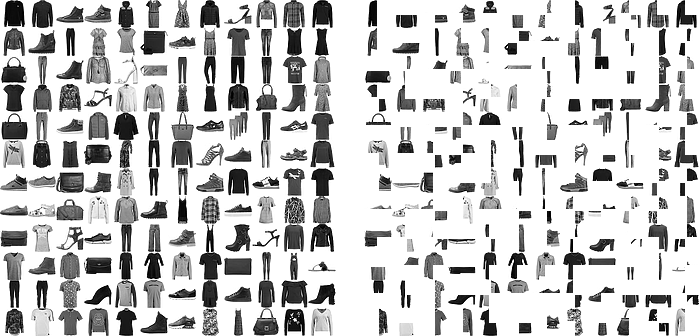

In [0]:
num_images = 12

display_images = Matrix(undef, num_images, num_images)
for i in 1:num_images, j in 1:num_images
    display_images[i,j] = rand(1:size(trainxs)[3])
end

whole = vcat([hcat([MNIST.convert2image(trainxs[:,:,display_images[i,j]]) for i in 1:num_images]...) for j in 1:num_images]...)
noisy = vcat([hcat([MNIST.convert2image(noisytrainxs[:,:,display_images[i,j]]) for i in 1:num_images]...) for j in 1:num_images]...)
middle = Gray.(ones(num_images*28,28))
hcat(whole, middle, noisy)

## 2.1: Implement an Autoencoder

The below autoencoder has been implemented in Julia using Flux. The hyperparameters available for tuning are: 
* Batch size
* Number of layers
* Size of layers
* Number of training epochs

The autoencoder is trained to reconstruct an image, based on a "noisy" image where one or two quadrants have been removed, called $x'$. The loss function is the MSE between the reconstructed image $f(x')$ and the original, non-noisy image $x$: 

$$ \mathcal{L} = \frac{1}{N} \sum_{i=1}^N \| f(x') - x\|_2$$

Because the objective of this autoencoder is to reconstruct images, rather than to embed the data into some smaller dimension, structures were considered which had both lower and higher dimensions than the input and output dimensions of 784.

In [0]:
function batchifyFlat(x, batchsize)
    n = size(x)[3]
    x = reshape(x, (784,:))
    data = []
    for i in 1:batchsize:n
        push!(data, x[:,i:min(i + batchsize - 1, n)])
    end
    return data
end;

In [0]:
# Define training and validation data in batches
dataX = gpu.(batchifyFlat(noisytrainxs, 500))
dataY = gpu.(batchifyFlat(trainxs, 500))
validdataX = gpu.(batchifyFlat(noisyvalidxs, 500))
validdataY = gpu.(batchifyFlat(validxs, 500))

# Define the network dimensions
N  = 128 #  Size of the encoding

encoder_sample = Dense(28^2, N, leakyrelu)
decoder_sample = Dense(N,    28^2, leakyrelu)

m_sample = Chain(encoder_sample, decoder_sample) |> gpu

loss_sample(x, y) = mse(m_sample(x), y)

loss_sample (generic function with 1 method)

In [0]:
# Train the model over 500 epochs, ensure it converges on the training set.
# Should take about 100 seconds.

loss_sample(x, y) = mse(m_sample(x), y)
evalcb = throttle(() -> @show(loss_sample(dataX[1], dataY[1])), 5)
opt = ADAM()

epochs = 500
trainLoss = zeros(epochs)
ps_sample = params(m_sample)

start = time()
for epoch in 1:epochs
    println("Epoch: ", epoch)
    Flux.train!(loss_sample, ps_sample, zip(dataX, dataY), opt, cb = evalcb)
    trainLoss[epoch] = loss_sample(fullBatchX[1], fullBatchY[1]).data
end
println("Time elapsed: ", time() - start)

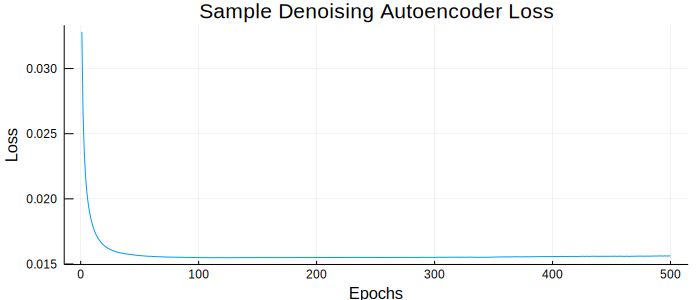

In [0]:
# Plot training loss to demonstrate that convergence is reached on this simple model.
plot(trainLoss, title="Sample Denoising Autoencoder Loss", xlabel="Epochs", ylabel="Loss", legend=false, size = (700, 300))


This plot demonstrates that convergence is easily reached on the training set, even with a simple autoencoder structure, meaning that it is complex enough to model our data. Our task from here on therefore is to find parameters which produce the best results on the validation set.

## 2.2: Explore model variants

The primary variables considered when exploring the model variants were number of layers, size of layers, and number of epochs.

Because accuracy is difficult to define in this context, we have used a combination of the loss over the validation set, and an assessment of reconstruct sample images, to determine good parameters for this model.

### 2.2.1 Number of epochs

We found that the training data converged after 25 epochs. Generally, the more parameters in the model, the sooner the model reached reasonable level of convergence.

![Convergence Graph](https://drive.google.com/uc?export=view&id=1cgzweAK4Gg2CgFwcesqiTvK38XA2EGPz)

Based on this analysis, models were trained to 50 epochs for further tests.

### 2.2.2 Size of layers

The pictures below show the difference between single-layer autoencoders of sizes 784-64-784 and 784-128-784. The higher dimensionality in the middle layer allows the autoencode to recognise and build specific weights for different sub-classes of clothing item. 

For example, the stiletto shoes are reconstructed more accurately in the autoencoder with the higher dimensionality. 

Of course, the higher the dimensionality, the more data is able to be transferred from input to output. This must be balanced against compute time and ability to generalise for unseen images.

Middle layer = 64: 
![alt text](https://drive.google.com/uc?export=view&id=1gpBMF-rhgjAtukJYlv5NGZyw08w6qZtw)

Middle layer = 128, validation loss = 0.01623
![alt text](https://drive.google.com/uc?export=view&id=1WeiUJDc3JgCXy-g3WN9j6GOuibCMHE0O)

Middle layer = 256, validation loss = 0.01424
![alt text](https://drive.google.com/uc?export=view&id=1F6DZqTab1OCT_Q9A4doNKvyYkE_uJpwu)

Middle layer - 512, validation loss = 0.01369
![alt text](https://drive.google.com/uc?export=view&id=1t2buQ-p_1MBm43axif7KGERr_yc4OHgL)

Middle layer = 1024, validation loss = 0.01347
![alt text](https://drive.google.com/uc?export=view&id=1jhKxNMxAzfPhrQQurfy7dsY9elcD_bHU)

Middle layer = 2048, validation loss = 0.01399
![alt text](https://drive.google.com/uc?export=view&id=1AHakOJVvA59iDhLfOatGsw53FZvi8vAb)



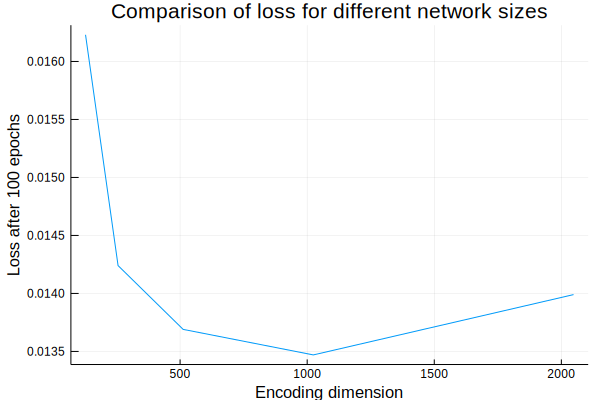

In [0]:
losses = [0.01623, 0.01424, 0.01369, 0.01347, 0.01399]
sizes = [128, 256, 512, 1024, 2048]
plot(sizes, losses, legend=false,xlabel="Encoding dimension",ylabel="Loss after 100 epochs",title="Comparison of loss for different network sizes")

### 2.2.3 Number of layers

Closely tied to the size of layers is the number of layers. 

The pictures below compare the results for networks of two and four layers, both trained to 100 epochs. 

*Network with dimensions 784-128-784*

Loss: 0.01623

![alt text](https://drive.google.com/uc?export=view&id=1IPxNJVCbpTBkSkUOz2ylX96MtEzIDXDj)


*Network with dimensions 784-128-128-128-784*

Loss: 0.01692

![alt text](https://drive.google.com/uc?export=view&id=1_O45Aa3B2fs6HxQ5zyLIPWLYTgeumRWp)

The results are relatively similar, but the two-layer network outperformed the four-layer on the basis of a visual inspection. Samples such as the stiletto and the bags were more clearly reconstructed by the two-layer network.

 The four-layer network did not achieve a lower loss over 100 epochs compared to the two-layer network (even under further testing over 200 epochs it did not quite beat the two-layer network)

### 2.2.4 Best network

Based on these results, the most effective network is a two-layer network with a middle dimension of 1024. This is implemented in the next section and trained to 60 epochs. 

## 2.3 Train your final model to convergence


In [0]:
# Define training and validation data
dataX = gpu.(batchifyFlat(noisytrainxs, 500))
dataY = gpu.(batchifyFlat(trainxs, 500))
validdataX = gpu.(batchifyFlat(noisyvalidxs, 500))
validdataY = gpu.(batchifyFlat(validxs, 500))

# Define full batch X and Y's for plotting the training and validation loss
fullBatchX = gpu.(batchifyFlat(noisytrainxs, 50000))
fullBatchY = gpu.(batchifyFlat(trainxs, 50000))
fullBatchValidX = gpu.(batchifyFlat(noisyvalidxs, 50000))
fullBatchValidY = gpu.(batchifyFlat(validxs, 50000));

In [0]:
# Set up the autoencoder structure

N  = 1024 #  Size of the encoding

encoder_final = Dense(28^2, N, leakyrelu)
decoder_final = Dense(N, 28^2, leakyrelu)

m_final = Chain(encoder_final, decoder_final) |> gpu;

In [0]:
# Train the model over 60 epochs
# Takes about 40 seconds

loss_final(x, y) = mse(m_final(x), y)
evalcb = throttle(() -> @show(loss_final(dataX[1], dataY[1])), 5)
opt = ADAM()

epochs = 60
trainLoss = zeros(epochs)
validLoss = zeros(epochs)
ps = params(m_final)

start = time()
for epoch in 1:epochs
    println("Epoch: ", epoch)
    Flux.train!(loss_final, ps, zip(dataX, dataY), opt, cb = evalcb)
    trainLoss[epoch] = loss_final(fullBatchX[1], fullBatchY[1]).data
    validLoss[epoch] = loss_final(fullBatchValidX[1], fullBatchValidY[1]).data
end
println("Time elapsed: ", time() - start)

## 2.4 Plot Training and Validation Loss

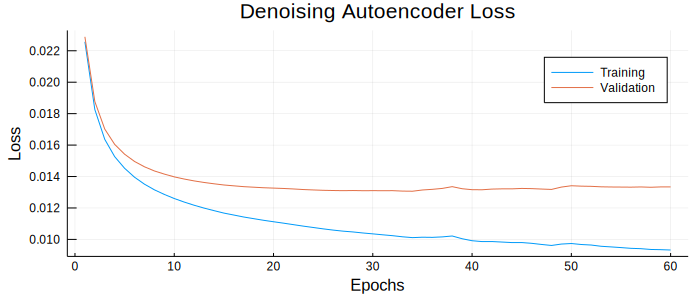

In [0]:
# Plot training and validation losses
plot([trainLoss, validLoss], title="Denoising Autoencoder Loss", xlabel="Epochs", ylabel="Loss", label = ["Training" "Validation" ], legend=true, size = (700, 300))


## 2.5 Provide Example Images

The below image shows 32 randomly chosen images. 



In [0]:
img(x::Vector) = Gray.(reshape(clamp.(x, 0, 1), 28, 28))

function reconstruct(model, imgs, noisyimgs, num_imgs = 20, rand_indices = [i for i in rand(1:size(imgs)[3], num_imgs)])
    
    before = hcat([MNIST.convert2image(imgs[:,:,rand_indices[i]]) for i in 1:num_imgs]...)
    
    noisy = hcat([MNIST.convert2image(noisyimgs[:,:,rand_indices[i]]) for i in 1:num_imgs]...)
    
    x_in = [imgs[:,:,i] for i in rand_indices]
    processed = map(x -> cpu(model)(vec(x)), x_in)
    rebuilt = hcat([MNIST.convert2image(processed[i].data) for i in 1:num_imgs]...)

    vcat(before, noisy, rebuilt)
end;

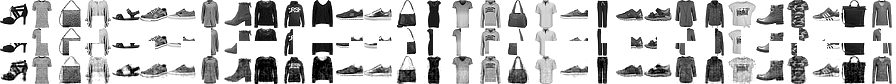

In [0]:
reconstruct(m_final, validxs, noisyvalidxs, 32)

The autoencoder appears to be able to reconstruct the general forms of all clothing classes with reasonable accuracy. Some key points are: 
* The reconstructions of bags are more blurry than other classes, probably due to the greater variation in shape compared to other classes
* Reconstructions of dresses do not capture the finer details as well as other classes. This is potentially due to the greater variation in shapes of dresses compared to other classes.
* The model did well at generalising to different sub-classes of garment, reconstructing examples such as t-shirts with different coloured sleeves with high accuracy. 
* Classes like t-shirts and jeans, with consistent shapes, were reconstructed well with very well defined edges.
* Although the shapes of objects were generally well reconstructed, features such as patterns or details on the fronts of tshirts were not reconstructed with high accuracy.